# Joint report plots

This notebook (along with `../autoencoder/report plots (joint).ipynb`) reproduces the figure in the Solid Earth paper which compares the WaveNet and conditional autoencoder networks together.

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import tensorflow as tf 
import sys
sys.path.insert(0, '../wavenet/')
from analysis import load_model, load_testdataset

In [2]:
# Global constants
DT = 0.002
T_GAIN = 2.5
DX,DZ = 5., 5.
NX,NZ = 128, 128-14
NREC,NSTEPS = 11, 512

letters = ['a','b','c','d','e','f','g','h','i','j','k','l','m']
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

DELTARECi=10

gain = np.arange(NSTEPS)**T_GAIN
gain = gain / np.median(gain)

## Run WaveNet

In [3]:
# Load model and dataset
tf.reset_default_graph()
model, c_dict, input_features, sess = load_model("new_forward_final", rootdir="../wavenet/server/", verbose=False)
d = load_testdataset("layers_2ms_validate.bin", N_EXAMPLES=1000, c_dict=c_dict, verbose=False)

# Get batches of test data
velocity_array, reflectivity_array, gather_array = d[:]
print(velocity_array.shape, reflectivity_array.shape, gather_array.shape)

# Inference
gather_prediction_array = sess.run(model.y, feed_dict={input_features["reflectivity"]: reflectivity_array})

Loading model from: ../wavenet/server/models/new_forward_final/model.ckpt-500000




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ../wavenet/server/models/new_forward_final/model.ckpt-500000
(1000, 114, 1) (1000, 512, 1) (1000, 512, 11)


## Load autoencoder results

In [4]:
# load AE predictions
trace_array_ae = np.load("../autoencoder/trace_array_ae.npy")[:,0,:,:].transpose(0,2,1)
print(trace_array_ae.shape, gather_prediction_array.shape)

(1000, 512, 11) (1000, 512, 11)


In [5]:
#get losses (averaged over gather)
n_examples = gather_prediction_array.shape[0]

loss1 = np.mean(np.abs(gain.reshape((1,NSTEPS,1))*(gather_prediction_array - gather_array)), axis=(1,2))
loss2 = np.mean(np.abs(gain.reshape((1,NSTEPS,1))*(trace_array_ae - gather_array)), axis=(1,2))

## Plot the results

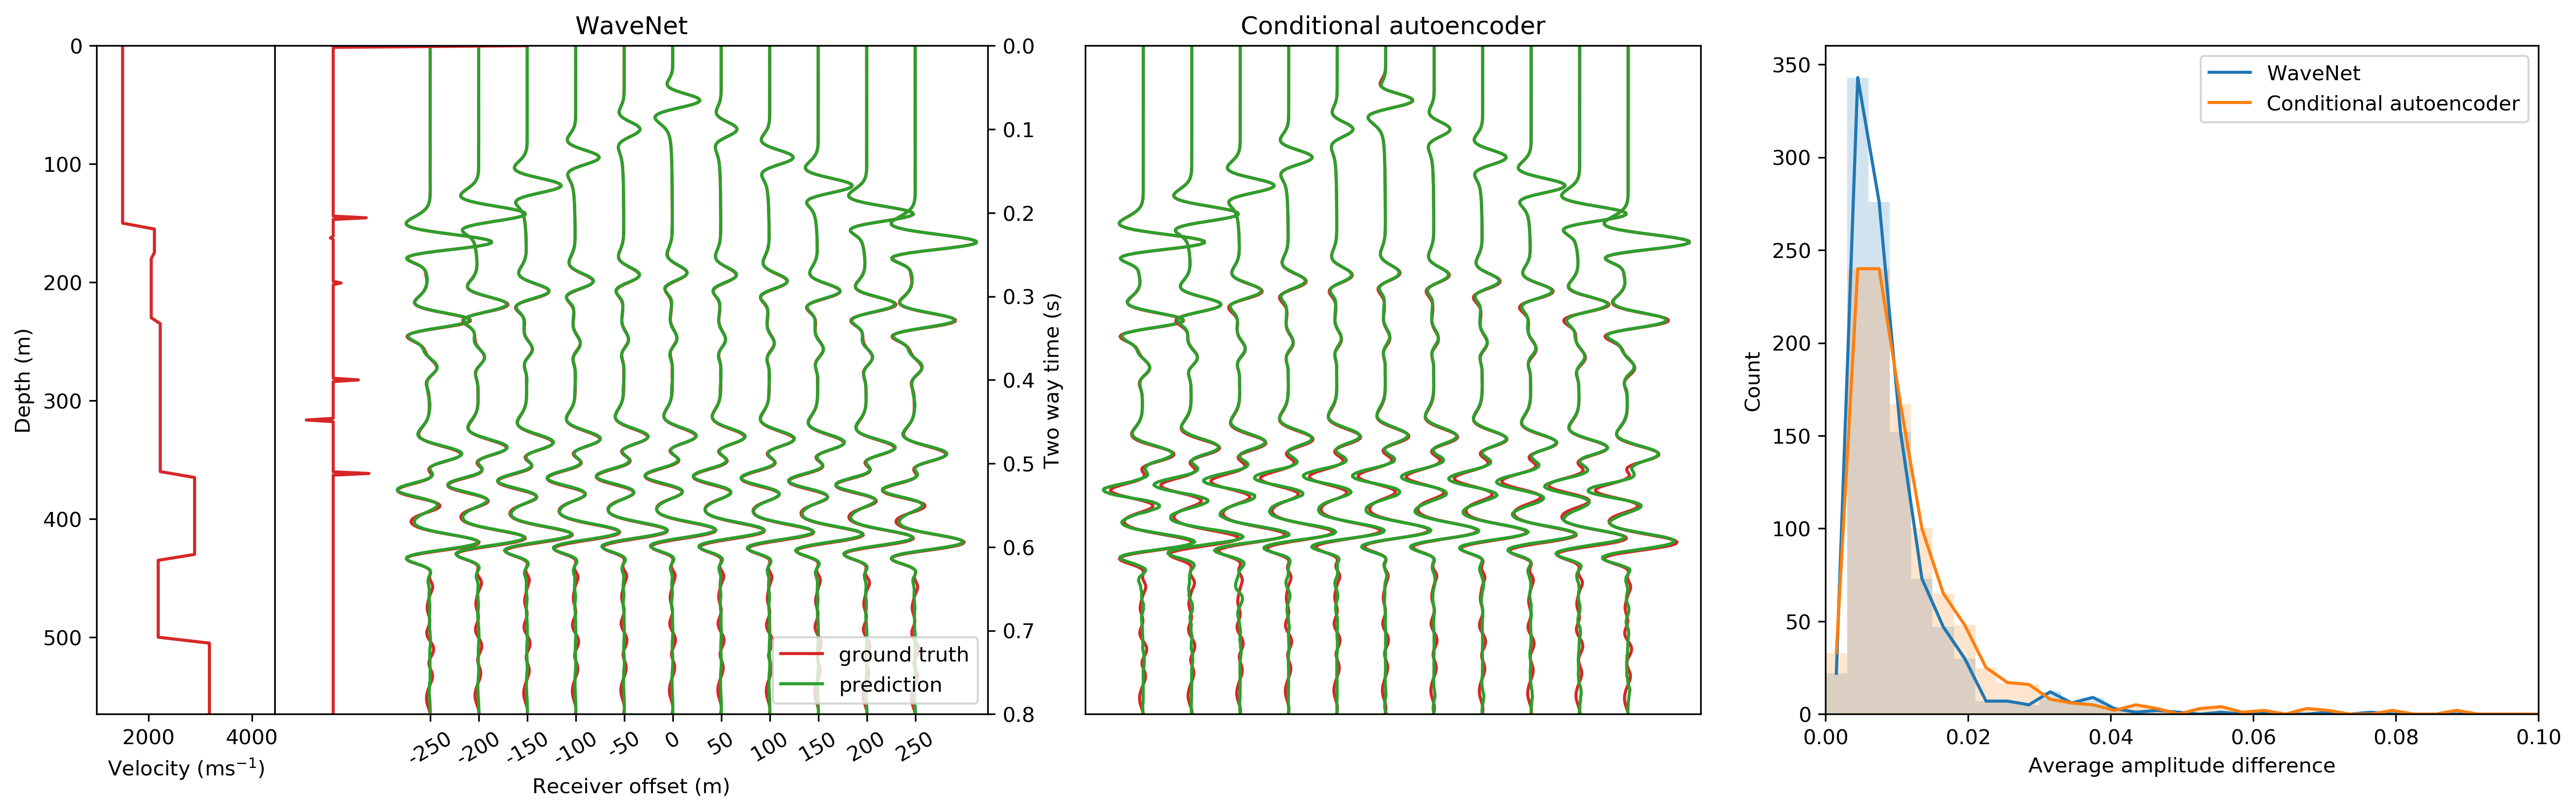

In [6]:
ib = 7

names = ["WaveNet","Conditional autoencoder"]
gather_prediction_arrays = [gather_prediction_array, trace_array_ae]
losses = [loss1, loss2]

def plot_gather(iname, label=True, reflectivity=True, xlabel=True, ylabel=True):
    
    # gather & reflectivity
    lim = 1.
    for ir in range(NREC): 
        if label and ir==0:
            label1="ground truth"
            label2="prediction"
        else: label1 = label2 = None
        
        plt.plot(lim*ir+gain*gather_array[ib,:,ir], DT*np.arange(NSTEPS), color='tab:red',label=label1)
        plt.plot(lim*ir+gain*gather_prediction_arrays[iname][ib,:,ir], DT*np.arange(NSTEPS), color='tab:green',label=label2)
    
    if reflectivity:
        plt.plot(-2*lim+4*reflectivity_array[ib,:,0], DT*np.arange(NSTEPS), color='tab:red')
    
    if label:
        plt.legend(loc=4)
    plt.title(names[iname])
    
    plt.gca().invert_yaxis()
    if xlabel:
        plt.xlabel("Receiver offset (m)")
        plt.xticks(np.arange(0, NREC*lim,lim), [int(-(NREC-1)*DELTARECi*DX/2 + irec*DELTARECi*DX) for irec in range(NREC)])
    else: 
        plt.xticks([])
    if ylabel:
        plt.ylabel("Two way time (s)")
    else: 
        plt.yticks([])
    plt.gca().yaxis.tick_right()
    plt.gca().yaxis.set_label_position("right")
    plt.ylim(DT*400,0)
    if reflectivity:
        plt.xlim(-3*lim-0.2, lim*(NREC-1)+lim+0.5)
    else: 
        plt.xlim(-1*lim-0.2, lim*(NREC-1)+lim+0.5)
    plt.xticks(rotation=30)
    
    
f = plt.figure(figsize=(12,10), dpi=300)

# velocity axis
ax = f.add_axes([0,0.55,
                 0.1,0.45])# xmin, ymin, dx, and dy
plt.plot(velocity_array[ib,:,0], DZ*np.arange(NZ), color='tab:red')
plt.gca().invert_yaxis()
plt.xlabel("Velocity ($\mathrm{ms}^{-1}$)")
plt.xlim(1000,4450)
plt.ylim(DZ*(NZ-1),0)
plt.ylabel("Depth (m)")

# gathers
iname=0
ax = f.add_axes([0.1, 0.55,
                 0.4,0.45])# xmin, ymin, dx, and dy
plot_gather(iname)
    
iname=1
ax = f.add_axes([0.5+0.0545,0.55,
                 0.4-0.0545,0.45])# xmin, ymin, dx, and dy
plot_gather(iname, reflectivity=False, xlabel=False, ylabel=False, label=False)
    
    
# loss
ax = f.add_axes([0.97,0.55,
             0.4,0.45])# xmin, ymin, dx, and dy

for iname in [0,1]:
    x = np.arange(0,0.2,0.003)
    plt.plot(x[:-1]+(x[1]-x[0])/2.,np.histogram(losses[iname], bins=x)[0], label=names[iname], color=colors[iname])
    plt.hist(losses[iname], bins=x, histtype='stepfilled', alpha=0.2, color=colors[iname])
plt.xlim(0,0.1)
plt.legend()
plt.ylabel("Count")
plt.xlabel("Average amplitude difference")

plt.savefig("../report_plots/figA3.pdf", bbox_inches='tight', pad_inches=0.01, dpi=300)